Merged data shape: (23374, 3)
Shape of 5-year dataset: (1826, 3)
X shape: (1797, 20, 2) y shape: (1797, 10, 2)


C:\Users\Sedaghat\AppData\Local\Temp\ipykernel_9280\3207288172.py:56: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  today = datetime.utcnow()
C:\Users\Sedaghat\anaconda3\envs\swot-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.7791
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6176
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4354
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3208
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2343
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1898
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1686
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1559
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1524
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1420
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1361
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1331
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1297
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1287
Epoch 15/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1244
Epoc

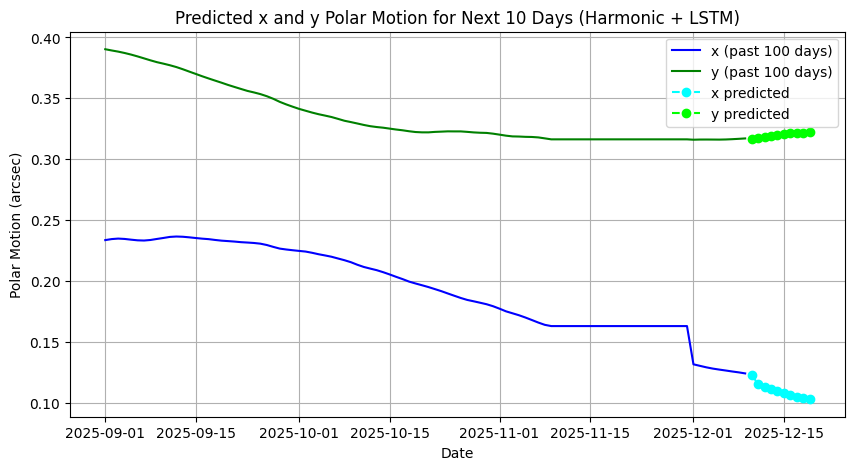

In [1]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import math

# =========================
# --- 1. Download and process data ---
# --- C04 file ---
url_c04 = "https://datacenter.iers.org/data/224/eopc04_14_IAU2000.62-now.txt"
resp = requests.get(url_c04, params={"downloadformat":"txt"})
with open("eop1.txt", "wb") as f: f.write(resp.content)

with open("eop1.txt", "r") as f:
    lines = f.readlines()[14:]  # skip header
c04_data = []
for line in lines:
    try:
        parts = list(map(float, line.strip().split()))
        c04_data.append(parts)
    except:
        continue
c04_data = np.array(c04_data)[:, [3, 4, 5]]  # MJD, x, y

# --- Bulletin file ---
url_bu = "https://datacenter.iers.org/data/13/finals2000A.daily"
resp = requests.get(url_bu, params={"downloadformat":"txt"})
with open("bu.txt","wb") as f: f.write(resp.content)

with open("bu.txt","r") as f:
    lines = f.readlines()[14:]
bu_data = []
for line in lines:
    parts = line.strip().split()
    if len(parts)>=7:
        try:
            bu_data.append([float(parts[2]), float(parts[4]), float(parts[6])])  # MJD, x, y
        except:
            continue
bu_data = np.array(bu_data)

# --- Merge datasets ---
last_c04_mjd = c04_data[-1,0]
bu_new = bu_data[bu_data[:,0] > last_c04_mjd]
all_data = np.vstack([c04_data, bu_new])
print("Merged data shape:", all_data.shape)

# =========================
# --- 2. Prepare 5-year dataset ---
today = datetime.utcnow()
start_date = today - timedelta(days=5*365)

def date_to_mjd(year, month, day):
    dt = datetime(year, month, day)
    a = (14 - dt.month)//12
    y = dt.year + 4800 - a
    m = dt.month + 12*a - 3
    jd = dt.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 32045
    mjd = jd - 2400000.5
    return mjd

mjd_start = date_to_mjd(start_date.year, start_date.month, start_date.day)
mjd_end = date_to_mjd(today.year, today.month, today.day)
mjd_range = np.arange(mjd_start, mjd_end+1, 1)

selected_data = []
for mjd in mjd_range:
    idx = np.where(all_data[:,0] <= mjd)[0]
    if len(idx)==0:
        continue
    selected_data.append(all_data[idx[-1]])
selected_data = np.array(selected_data)
print("Shape of 5-year dataset:", selected_data.shape)

# =========================
# --- 3. Convert to DataFrame ---
data = pd.DataFrame(selected_data[:,1:3], columns=['x','y'])
dates = pd.date_range(end=pd.Timestamp.utcnow().normalize(), periods=len(data))
data.index = dates

# =========================
# --- 4. Harmonic model with t0 = last day of real data ---
def build_design_matrix(dates, periods, t0=None):
    if t0 is None:
        t0 = dates[0]
    tdays = (dates - t0).total_seconds() / 86400.0
    N = len(tdays)
    cols = [np.ones(N), tdays]  # intercept and linear trend
    for P in periods:
        omega = 2*math.pi/P
        cols.append(np.sin(omega*tdays))
        cols.append(np.cos(omega*tdays))
    return np.vstack(cols).T

periods = [365.25, 433.0, 365.25/2.0]
# design harmonic model on real data
X_design = build_design_matrix(data.index, periods)
harmonic = pd.DataFrame(index=data.index, columns=['x','y'], dtype=float)
coefs = {}
for col in ['x','y']:
    beta, _, _, _ = np.linalg.lstsq(X_design, data[col].values, rcond=None)
    coefs[col] = beta
    harmonic[col] = X_design.dot(beta)

# compute residuals
residuals = data - harmonic

# =========================
# --- 5. Standardize residuals ---
scaler = StandardScaler()
residuals_scaled = scaler.fit_transform(residuals.values)

# =========================
# --- 6. Create sequences for LSTM ---
look_back = 20
n_steps_out = 10
n_features = residuals_scaled.shape[1]

def create_sequences(data_scaled, look_back, n_steps_out):
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_steps_out + 1):
        X.append(data_scaled[i:i+look_back])
        y.append(data_scaled[i+look_back:i+look_back+n_steps_out])
    return np.array(X), np.array(y)

X, y = create_sequences(residuals_scaled, look_back, n_steps_out)
print("X shape:", X.shape, "y shape:", y.shape)

# =========================
# --- 7. Define LSTM model ---
model = Sequential([
    LSTM(16, activation='tanh', return_sequences=True, input_shape=(look_back, n_features)),
    Dropout(0.1),
    LSTM(8, activation='tanh'),
    Dense(n_steps_out * n_features)
])
model.compile(optimizer=Adam(0.001), loss='mae')

# =========================
# --- 8. Train model ---
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model.fit(X, y.reshape(y.shape[0], -1), epochs=30, batch_size=32, callbacks=[early_stop], verbose=1)

# =========================
# --- 9. Predict next 10 days ---
input_seq = residuals_scaled[-look_back:].copy()
pred_residuals_scaled = []

for day in range(n_steps_out):
    y_pred_full = model.predict(input_seq[np.newaxis,:,:], verbose=0)
    y_pred_full = y_pred_full.reshape(n_steps_out, n_features)
    y_pred_day = y_pred_full[0]
    pred_residuals_scaled.append(y_pred_day)
    input_seq = np.vstack([input_seq[1:], y_pred_day])

pred_residuals_scaled = np.array(pred_residuals_scaled)
pred_residuals = scaler.inverse_transform(pred_residuals_scaled)

# =========================
# --- 10. Compute future harmonic with t0 = last day of real data ---
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps_out, freq='D')
X_future = build_design_matrix(future_dates, periods, t0=data.index[0])
harmonic_future = pd.DataFrame(index=future_dates, columns=['x','y'], dtype=float)
for col in ['x','y']:
    harmonic_future[col] = X_future.dot(coefs[col])

# =========================
# --- 11. Combine residual + harmonic and correct continuity ---
# offset correction for first prediction day
first_offset = (data.iloc[-1].values - harmonic.iloc[-1].values - pred_residuals[0])
pred_residuals[0] += first_offset

pred_df = pd.DataFrame(pred_residuals, index=future_dates, columns=['x','y']) + harmonic_future

print("Predicted x and y for next 10 days:")
print(pred_df)

# =========================
# --- 12. Plot results ---
plt.figure(figsize=(10,5))
plt.plot(data.index[-100:], data['x'][-100:], label='x (past 100 days)', color='blue')
plt.plot(data.index[-100:], data['y'][-100:], label='y (past 100 days)', color='green')
plt.plot(pred_df.index, pred_df['x'], 'o--', label='x predicted', color='cyan')
plt.plot(pred_df.index, pred_df['y'], 'o--', label='y predicted', color='lime')
plt.xlabel("Date")
plt.ylabel("Polar Motion (arcsec)")
plt.title("Predicted x and y Polar Motion for Next 10 Days (Harmonic + LSTM)")
plt.legend()
plt.grid(True)
plt.show()
